# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [ ]:
!pip install imblearn

     |████████████████████████████████| 226 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 2.7 MB/s eta 0:00:01     |███████████▎                    | 3.4 MB 5.3 MB/s eta 0:00:02
     |████████████████████████████████| 297 kB 24.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
!pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 43 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install shap

     |████████████████████████████████| 572 kB 1.8 MB/s eta 0:00:01


In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 2.1 MB/s ta 0:00:01


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize
from skopt.space import (
    Categorical,
    Integer,
    Real
)
from sklearn.metrics import (
    classification_report,
    f1_score, recall_score,
    make_scorer, precision_score)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import phik
import seaborn as sns
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

Data

In [ ]:
try:
    train = pd.read_csv('/datasets/hotel_train.csv')
    test = pd.read_csv('/datasets/hotel_test.csv')
except:
    train = pd.read_csv('/content/hotel_train.csv', error_bad_lines=False)
    test = pd.read_csv('/content/hotel_test.csv', error_bad_lines=False)

In [ ]:
train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [ ]:
test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


### Шаг 2. Предобработка и исследовательский анализ данных

In [ ]:
train.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [ ]:
test.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [ ]:
train.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [ ]:
test.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [ ]:
train.select_dtypes(include = 'object').columns

Index(['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type'],
      dtype='object')

<div class="alert alert-info">
Дубликатов нет
<div>

In [ ]:
train.duplicated(keep = False).sum()

0

In [ ]:
test.duplicated(keep = False).sum()

0

<div class="alert alert-info">
Сравню уникальные значения в train и test
<div>

In [ ]:
columns_to_check = ['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type']
not_equal_col = [
    f'test[{column}] != train[{column}]'
    for column in columns_to_check
    if set(test[column]) != set(train[column])
]
print(not_equal_col)

['test[arrival_date_month] != train[arrival_date_month]', 'test[country] != train[country]']


In [ ]:
print(set(train['arrival_date_month']) - set(test['arrival_date_month']))
print(set(train['country']) - set(test['country']))

{'October', 'September', 'December', 'November'}
{'BWA', 'PYF', 'GEO', 'OMN', 'PLW', 'MKD', 'CYM', 'ARM', 'BDI', 'MWI', 'UGA', 'ZMB', 'BOL', 'NIC', 'BRB', 'KNA', 'NAM', 'VGB', 'MLI', 'GUY', 'SMR', 'TMP', 'DMA', 'HND', 'LCA', 'GGY', 'GLP', 'RWA', 'BFA', 'KHM', 'MMR'}


<div class="alert alert-info">
В датасетах есть отличающиеся значения, но тк они присутствуют они в train, то не должно быть ничего страшного для OHE.
</div>

Посмотрим на выбросы

<div class="alert alert-info">
Графики
</div>

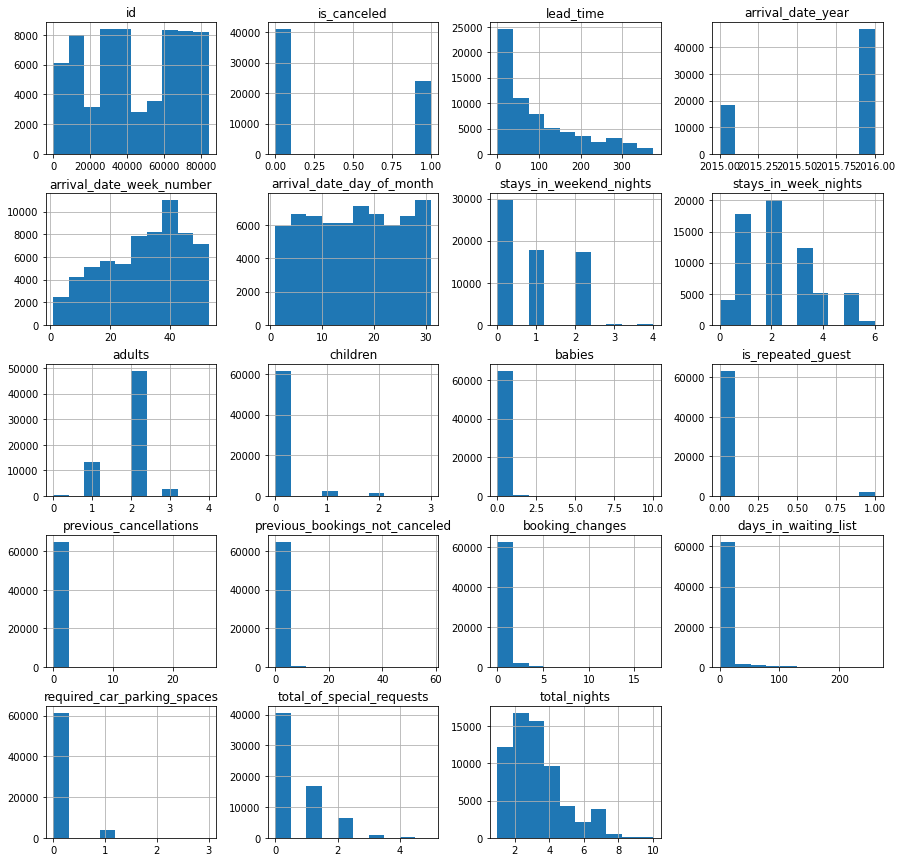

In [ ]:
train.hist(figsize = (15, 15));

<div class="alert alert-info">
heatmap для корреляции. phik, тк устанавливает не только линейные зависимости
</div>

interval columns not set, guessing: ['id', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


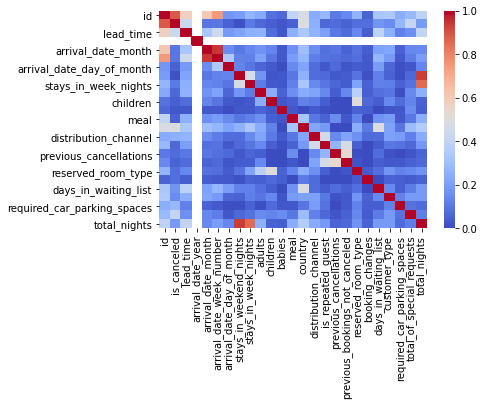

In [ ]:
phik_matrix = train.phik_matrix();
sns.heatmap(phik_matrix, cmap='coolwarm');

In [ ]:
train['is_canceled'].value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

In [ ]:
test['is_canceled'].value_counts()

0    19821
1    12591
Name: is_canceled, dtype: int64

<div class="alert alert-info">
id может быть одним из ключевых признаков, он может отражать длительность пользования платформы пользователем + там наблюдается довольно сильная корреляция. Наблюдается дисбаланс классов 1.71 / 1, 0 / 1.
   
</div>

In [ ]:
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)
train.shape

(65229, 24)

In [ ]:
print(train['meal'].unique())
print(train['reserved_room_type'].unique())

['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']


In [ ]:
for col in ['meal', 'reserved_room_type']:
    train[col] = train[col].apply(lambda x: x.strip())
print(train['meal'].unique())
print(train['reserved_room_type'].unique())

['BB' 'FB' 'HB' 'SC']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


In [ ]:
cols = ['lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'stays_in_weekend_nights', 'adults', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']
pd.Series(cols).unique()

array(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'], dtype=object)

In [ ]:
cols = ['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']

z_scores = stats.zscore(train[cols])

threshold = 3

outliers = (abs(z_scores) > threshold)
train[outliers].count()

is_canceled                          0
lead_time                            0
arrival_date_year                    0
arrival_date_month                   0
arrival_date_week_number             0
arrival_date_day_of_month            0
stays_in_weekend_nights            152
stays_in_week_nights                 0
adults                             179
children                          1352
babies                             452
meal                                 0
country                              0
distribution_channel                 0
is_repeated_guest                 1771
previous_cancellations             166
previous_bookings_not_canceled     396
reserved_room_type                   0
booking_changes                   2419
days_in_waiting_list              1383
customer_type                        0
required_car_parking_spaces       3682
total_of_special_requests         1156
total_nights                       270
dtype: int64

In [ ]:
cols = ['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']
z_scores = stats.zscore(test[cols])

threshold = 3

outliers = (abs(z_scores) > threshold)
test[outliers].count()

is_canceled                          0
lead_time                          100
arrival_date_year                    0
arrival_date_month                   0
arrival_date_week_number             0
arrival_date_day_of_month            0
stays_in_weekend_nights             70
stays_in_week_nights                 0
adults                              78
children                           658
babies                             175
meal                                 0
country                              0
distribution_channel                 0
is_repeated_guest                 1017
previous_cancellations             226
previous_bookings_not_canceled     273
reserved_room_type                   0
booking_changes                    442
days_in_waiting_list               138
customer_type                        0
required_car_parking_spaces       1477
total_of_special_requests          142
total_nights                       117
dtype: int64

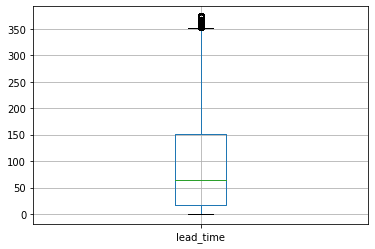

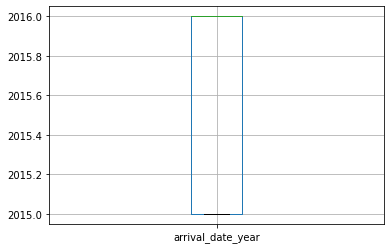

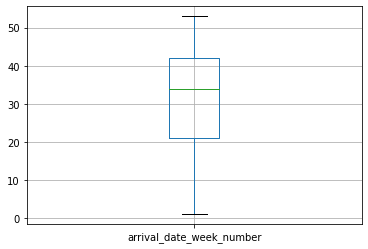

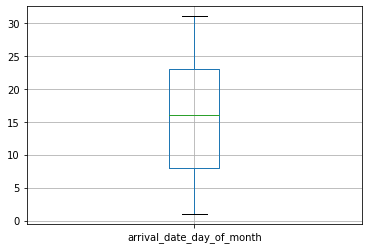

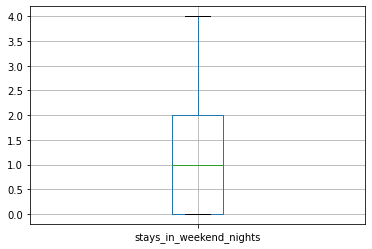

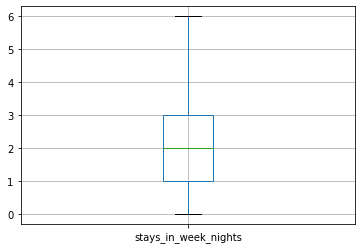

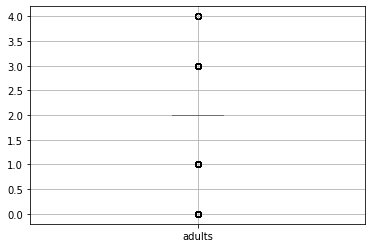

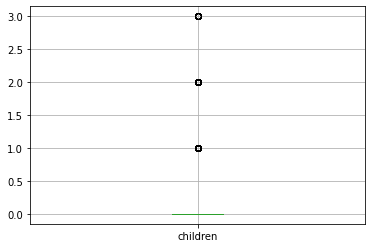

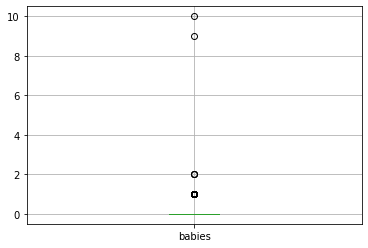

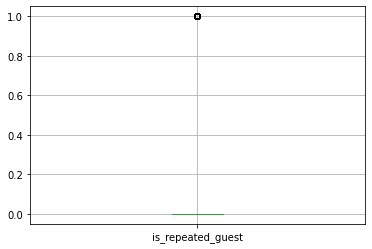

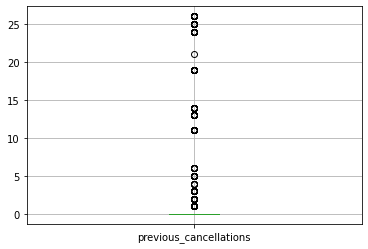

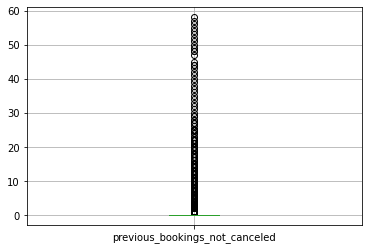

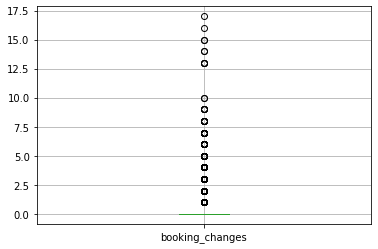

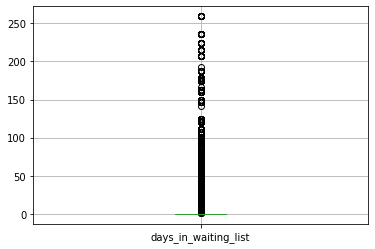

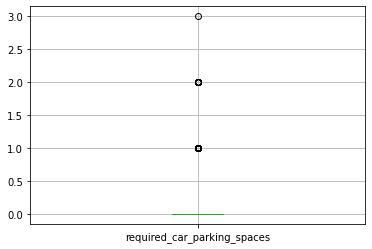

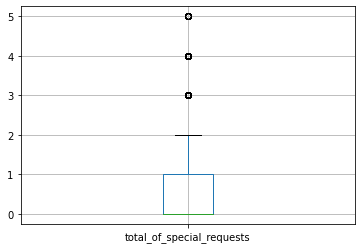

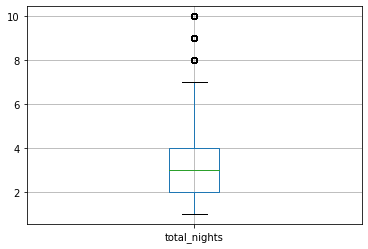

In [ ]:
cols = ['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']
for col in cols:
    train.boxplot(column = col)
    plt.show()

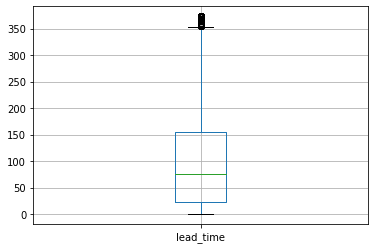

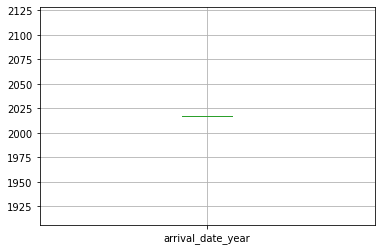

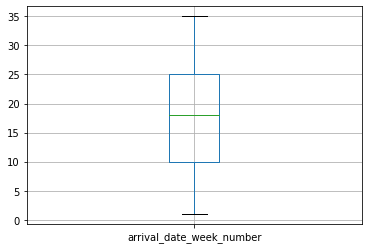

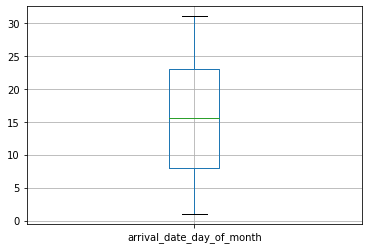

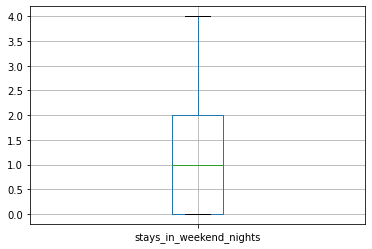

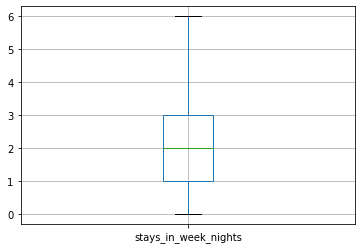

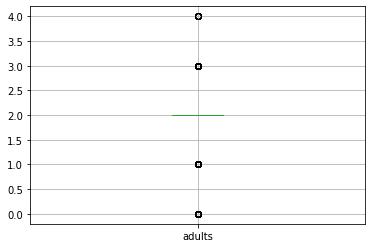

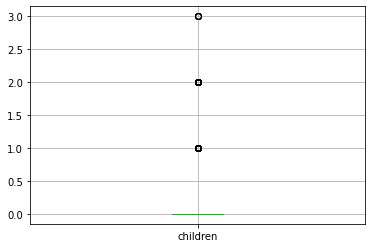

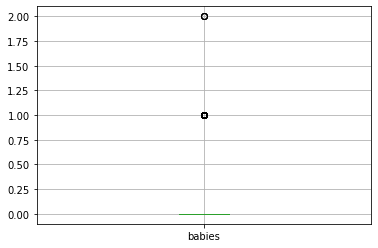

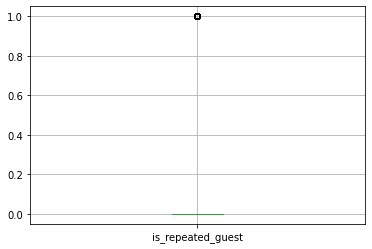

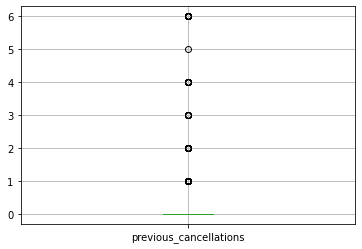

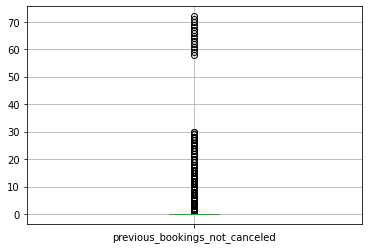

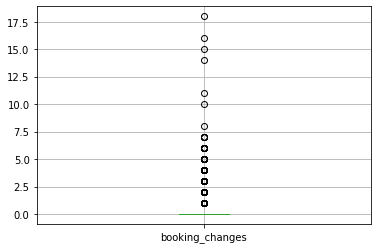

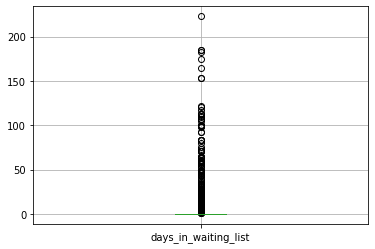

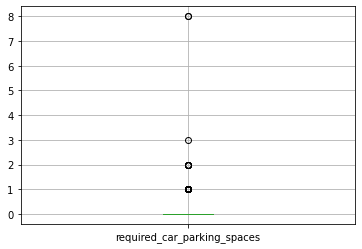

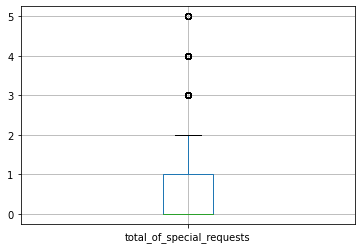

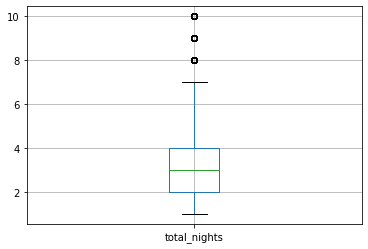

In [ ]:
cols = ['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']
for col in cols:
    test.boxplot(column = col)
    plt.show()

In [ ]:
cols = ['lead_time', 'arrival_date_year', 'arrival_date_week_number',
        'arrival_date_day_of_month', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies',
        'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'booking_changes',
        'days_in_waiting_list', 'required_car_parking_spaces',
        'total_of_special_requests', 'total_nights']

q1 = train[cols].quantile(0.25)
q3 = train[cols].quantile(0.75)
iqr = q3 - q1

thresh = 1.5

train = train[((train[cols] < (q1 - thresh*iqr)) | (train[cols] > (q3 + thresh*iqr))).any(axis=1)]
test = test[((test[cols] < (q1 - thresh*iqr)) | (test[cols] > (q3 + thresh*iqr))).any(axis=1)]

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [ ]:
features_train = train.drop(['is_canceled'], axis = 1)
target_train = train['is_canceled']
features_test = test.drop(['is_canceled'], axis = 1)
target_test = test['is_canceled']

In [ ]:
features_train.select_dtypes(include = 'object').columns

Index(['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type'],
      dtype='object')

In [ ]:
features_test.select_dtypes(include = 'object').columns

Index(['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type'],
      dtype='object')

<div class="alert alert-info">
    Тут при запуске нужно дождаться, пока он дозапустит, тк по какой-то причине, он не дождавшись завершения действий в ячейке, он запускает дальше.
</div>

In [ ]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Колонки, которые надо перевести
ohe_features = ['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type']

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])


features_test = features_test.drop(ohe_features, axis=1)

In [ ]:
features_train = features_train.rename(columns=lambda x: x.strip())
features_test = features_test.rename(columns=lambda x: x.strip())
features_train.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'customer_type_Contract', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party'],
      dtype='object', length=175)

In [ ]:
columns = ['reserved_room_type_' + letter for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']]
crt = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
features_train = features_train.rename(columns = {columns[0]:crt[0], columns[1]:crt[1], columns[2]:crt[2], columns[3]:crt[3], columns[4]:crt[4], columns[5]:crt[5], columns[6]:crt[6]})
features_train.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'B', 'C', 'D', 'E', 'F', 'G', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=175)

In [ ]:
columns = ['reserved_room_type_' + letter for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']]
crt = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
features_test = features_test.rename(columns = {columns[0]:crt[0], columns[1]:crt[1], columns[2]:crt[2], columns[3]:crt[3], columns[4]:crt[4], columns[5]:crt[5], columns[6]:crt[6]})
features_test.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'B', 'C', 'D', 'E', 'F', 'G', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=175)

In [ ]:
columns = ['arrival_date_month_' + month for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]
crt = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
features_train = features_train.rename(columns = {columns[0]:crt[0], columns[1]:crt[1], columns[2]:crt[2], columns[3]:crt[3], columns[4]:crt[4], columns[5]:crt[5], columns[6]:crt[6], columns[7]:crt[7], columns[8]:crt[8], columns[9]:crt[9], columns[10]:crt[10], columns[11]:crt[11]})
features_train.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'B', 'C', 'D', 'E', 'F', 'G', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=175)

In [ ]:
columns = ['arrival_date_month_' + month for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]
crt = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
features_test = features_test.rename(columns = {columns[0]:crt[0], columns[1]:crt[1], columns[2]:crt[2], columns[3]:crt[3], columns[4]:crt[4], columns[5]:crt[5], columns[6]:crt[6], columns[7]:crt[7], columns[8]:crt[8], columns[9]:crt[9], columns[10]:crt[10], columns[11]:crt[11]})
features_test.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'B', 'C', 'D', 'E', 'F', 'G', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=175)

In [ ]:
def calculate_revenue(row, arg):
    revenue = 0
    if arg == 0:
        if row['is_canceled'] == 0:
            if row['B'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 800 * 1.2 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 800 * 1.4 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                else:
                    revenue = 800 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
            elif row['C'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 600 * 1.2 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 600 * 1.4 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                else:
                    revenue = 600 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
            elif row['D'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 550 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 550 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 550 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['E'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 500 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 500 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 500 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['F'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 450 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 450 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 450 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['G'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 350 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 350 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 350 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            else:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 1000 * 1.2 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 1000 * 1.4 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
                else:
                    revenue = 1000 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
        else:
            if row['B'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -800 * 1.2 - 350
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -800 * 1.4 - 350
                else:
                    revenue = -800 - 350
            elif row['C'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -600 * 1.2 - 350
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -600 * 1.4 - 350
                else:
                    revenue = -600 - 350
            elif row['D'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -550 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -550 * 1.4 - 150
                else:
                    revenue = -550 - 150
            elif row['E'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -500 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -500 * 1.4 - 150
                else:
                    revenue = -500 - 150
            elif row['F'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -450 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -450 * 1.4 - 150
                else:
                    revenue = -450 - 150
            elif row['G'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -350 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -350 * 1.4 - 150
                else:
                    revenue = -350 - 150
            else:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -1000 * 1.2 - 400
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -1000 * 1.4 - 400
                else:
                    revenue = -1000 - 400
    else:
        if row['predictions'] == 0 and row['is_canceled'] == 0:
            if row['B'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 800 * 1.2 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 800 * 1.4 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                else:
                    revenue = 800 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
            elif row['C'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 600 * 1.2 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 600 * 1.4 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                else:
                    revenue = 600 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
            elif row['D'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 550 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 550 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 550 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['E'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 500 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 500 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 500 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['F'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 450 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 450 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 450 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['G'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 350 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 350 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 350 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            else:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 1000 * 1.2 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 1000 * 1.4 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
                else:
                    revenue = 1000 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
        elif row['predictions'] == 0 and row['is_canceled'] == 1:
            if row['B'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -800 * 1.2 - 350
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -800 * 1.4 - 350
                else:
                    revenue = -800 - 350
            elif row['C'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -600 * 1.2 - 350
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -600 * 1.4 - 350
                else:
                    revenue = -600 - 350
            elif row['D'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -550 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -550 * 1.4 - 150
                else:
                    revenue = -550 - 150
            elif row['E'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -500 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -500 * 1.4 - 150
                else:
                    revenue = -500 - 150
            elif row['F'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -450 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -450 * 1.4 - 150
                else:
                    revenue = -450 - 150
            elif row['G'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -350 * 1.2 - 150
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -350 * 1.4 - 150
                else:
                    revenue = -350 - 150
            else:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -1000 * 1.2 - 400
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -1000 * 1.4 - 400
                else:
                    revenue = -1000 - 400
        elif row['predictions'] == 1 and row['is_canceled'] == 0:
            if row['B'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 800 * 1.2 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 800 * 1.4 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                else:
                    revenue = 800 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
            elif row['C'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 600 * 1.2 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 600 * 1.4 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
                else:
                    revenue = 600 * row['total_nights'] - 350 - 350 * row['total_nights'] // 2
            elif row['D'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 550 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 550 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 550 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['E'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 500 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 500 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 500 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['F'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 450 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 450 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 450 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            elif row['G'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 350 * 1.2 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 350 * 1.4 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
                else:
                    revenue = 350 * row['total_nights'] - 150 - 150 * row['total_nights'] // 2
            else:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = 1000 * 1.2 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = 1000 * 1.4 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
                else:
                    revenue = 1000 * row['total_nights'] - 400 - 400 * row['total_nights'] // 2
        else:
            if row['B'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(800 * 1.2 + 350) + (800 * 1.2 + 350) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(800 * 1.4 + 350) + (800 * 1.4 + 350) * 0.8
                else:
                    revenue = -(800 + 350) + (800 + 350) * 0.8
            elif row['C'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(600 * 1.2 + 350) + (600 * 1.2 + 350) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(600 * 1.4 + 350) + (600 * 1.4 + 350) * 0.8
                else:
                    revenue = -(600 + 350) + (600 + 350) * 0.8
            elif row['D'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(550 * 1.2 + 150) + (550 * 1.2 + 150) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(550 * 1.4 + 150) + (550 * 1.4 + 150) * 0.8
                else:
                    revenue = -(550 + 150) + (550 + 150) * 0.8
            elif row['E'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(500 * 1.2 + 150) + (500 * 1.2 + 150) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(500 * 1.4 + 150) + (500 * 1.4 + 150) * 0.8
                else:
                    revenue = -(500 + 150) + (500 + 150) * 0.8
            elif row['F'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(450 * 1.2 + 150) + (450 * 1.2 + 150) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(450 * 1.4 + 150) + (450 * 1.4 + 150) * 0.8
                else:
                    revenue = -(450 + 150) + (450 + 150) * 0.8
            elif row['G'] == 1:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(350 * 1.2 + 150) + (350 * 1.2 + 150) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(350 * 1.4 + 150) + (350 * 1.4 + 150) * 0.8
                else:
                    revenue = -(350 + 150) + (350 + 150) * 0.8
            else:
                if row['3'] == 1 or row['4'] == 1 or row['5'] == 1 or row['9'] == 1 or row['10'] == 1 or row['11'] == 1:
                    revenue = -(1000 * 1.2 + 400) + (1000 * 1.2 + 400) * 0.8
                elif row['6'] == 1 or row['7'] == 1 or row['8'] == 1:
                    revenue = -(1000 * 1.4 + 400) + (1000 * 1.4 + 400) * 0.8
                else:
                    revenue = -(1000 + 400) + (1000 + 400) * 0.8

    return revenue

In [ ]:
test_2_calc = pd.concat([features_test, target_test], axis = 1)
test_2_calc['revenue'] = test_2_calc.apply(calculate_revenue, arg = 0, axis = 1)
test_2_calc['revenue'].sum()

19897600.0

Не знаю, надо было считать на тестовой или нет. Скорее нет, чем да, но посчитал, на всякий случай

<div class="alert alert-info">
Вывод: По результатам работы функции по подсчету прибыли, учитывая только фактическую - отмена, составила - 19_897_600.
</div>

In [ ]:
param_vals = {"classification__max_depth": [3, 5, 7, 9, 11, 13, 15],
              "classification__learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

scorer = make_scorer(precision_score)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# Создаем пайплайн
gbc_pipeline = imbPipeline([("oversampler", RandomOverSampler(random_state=12345)),
                             ("classification", GradientBoostingClassifier(n_estimators=100, random_state=12345))])

grid_gbc = GridSearchCV(gbc_pipeline, param_grid=param_vals, cv=skf,
                        scoring={"precision": scorer, "f1": "f1"}, refit="precision", n_jobs=-1)

grid_gbc.fit(features_train, target_train)

# Получаем итоговые метрики и параметры
best_params = grid_gbc.best_params_
best_precision = grid_gbc.best_score_
best_f1 = grid_gbc.cv_results_["mean_test_f1"][grid_gbc.best_index_]

print(f'Лучшие параметры: {best_params}')
print(f'Precision: {best_precision}')
print(f'F1-score: {best_f1}')

<div class="alert alert-info">
Лучшая модель - случайный лес. F1: 0.9638395792241946, Recall: 0.9649498107618891 на кросс валидации
</div>

### Шаг 5. Портрет "плохого" клиента

In [ ]:
model_to_exp = GradientBoostingClassifier(n_estimators=100, max_depth = 15, learning_rate = 0.3, random_state=12345).fit(features_train, target_train)

feature_importances = model_to_exp.feature_importances_
cols = ['lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']
# Создаем список названий признаков
features_list = features_test[cols][:-1]

# Создаем словарь из пар "название признака - вес"
feature_importances_dict = dict(zip(features_list, feature_importances))

# Сортируем словарь по значению
sorted_feature_importances_dict = dict(sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True))

# Отобразим значимость признаков на графике
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_importances_dict.keys(), sorted_feature_importances_dict.values())
plt.xticks(rotation='vertical')
plt.title("Значимость признаков")
plt.show()

Вывод: Для визуализации воспользовался шапом

In [ ]:
model_gb = GradientBoostingClassifier(n_estimators=100, max_depth = 15, learning_rate = 0.3, random_state=12345).fit(features_train, target_train)
pred = model_gb.predict(features_test)
print(f'F1: {f1_score(target_test, pred)}')
print(f'Precision: {precision_score(target_test, pred)}')

In [ ]:
predictions = pd.Series(model_gb.predict(features_test))
predictions.value_counts()

In [ ]:
target_test

In [ ]:
features_test

In [ ]:
target_test = target_test.reset_index(drop = True)
predictions = predictions.reset_index(drop = True)
features_test = features_test.reset_index(drop = True)

In [ ]:
target_test

In [ ]:
features_test

In [ ]:
features_test['is_canceled'] = target_test
features_test['predictions'] = predictions
features_test['revenue'] = features_test.apply(calculate_revenue, arg = 1, axis = 1)
abs(features_test['revenue'].sum())

Вывод:  Основными критерями для запроса предоплаты с человека являются:
* lead_time - количество дней между датой бронирования и датой прибытия,
* total_of_special_requests - кол-во специальных отметок,
* arrival_date_week_number - неделя заезда
* arrival_date_day_of_month - день заезда
* previous_cancellations - кол-во отменённых заказов у клиента

### Шаг 6. Напишите общий вывод

Вывод: В начале было проведено исследование с помощью гистограмм и уникальных значений в столбцах, так же построен график корреляции. На этапе формулирования ML задачи был использован энкодер для кодирования категориальных признаков. Написана функция для подсчета прибыли. Прибыль до внедрения модели была равна 19_897_600. В качетсве моделей были выбраны случайный лес и градиентный бустинг. По итогу сравнений показателей на кросс валидации, градиентный бустинг показал себя лучше, Precision: 86%, F1-score: 84%. В перспективе целесообразно совершенствование модели градиентного бустинга и других моделей машинного обучения посредством включения дополнительных, ранее не учтенных гиперпараметров. По итогу внедрение модели, компания может заработать 22_331_040, не считая того, что без внедрения модели она заработает 19_897_600, а если применить машинное обучение, то ее заработок составит 22_331_040. Компания заработает дополнительно 2_433_440, из этих денег 400_000 уйдет на разработку системы депозитов, из чего следует, что компания увеличит свой доход на 2_033_440.